In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
import ipywidgets as widgets
%matplotlib notebook

## How to run this notebook ?

After executing the whole file
* you may freely choose the values of $m$ and $\omega_0$ using the sliders
* a left-click and drag into an axis will allow you to zoom into the coordinates (time or frequency)
* a right-click will go back to the original zoom

In [14]:
# The functions to be called

def stepresponse(m, omega0, K=1):
    if m == 1:
        def resp(t):
            return K * (t >= 0) * (1 + np.exp(-omega0 * t) * (omega0 * t - 1))
    elif m > 1:
        def resp(t):
            csh = np.cosh(omega0 * np.sqrt(m ** 2 - 1) * t)
            snh = m / np.sqrt(m ** 2 - 1) * np.sinh(omega0 * np.sqrt(m ** 2 - 1) * t)
            return K * (t>=0) * (1 - np.exp(-omega0 * m * t) * (csh + snh))
    else:
        def resp(t):
            cs = np.cos(omega0 * np.sqrt(1 - m ** 2) * t)
            sn = m / np.sqrt(1 - m ** 2) * np.sin(omega0 * np.sqrt(1 - m ** 2) * t)
            return K * (t>=0) * (1 - np.exp(-omega0 * m * t) * (cs - m / np.sqrt(1 - m ** 2) * sn))
    return resp

def impulseresponse(m, omega0, K=1):
    if m == 1:
        def resp(t):
            return K * (t >= 0) * omega0 ** 2 * t * np.exp(-omega0 * m *t)
    elif m > 1:
        def resp(t):
            return K * (t>=0) * omega0 / np.sqrt(m ** 2 - 1) * np.exp(-m * omega0 * t) * \
                np.sinh(omega0 * np.sqrt(m ** 2 - 1) * t)
    else:
        def resp(t):
            return K * (t>=0) * omega0 / np.sqrt(1 - m ** 2) * np.exp(-m * omega0 * t) * \
                np.sin(omega0 * np.sqrt(1 - m ** 2) * t)
    return resp

def frequencyresponse(m, omega0, K=1):
    def amplitude(omega):
        omegac = omega / omega0
        return 1 / np.sqrt((omegac ** 2 + 1) ** 2 + 4 * (m ** 2 - 1) * omegac ** 2)
    def phase(omega):
        return np.arctan2(-2 * m * omega0 * omega, omega0 ** 2 - omega ** 2)
    return amplitude, phase

# The widgets used to get the parameters

wgomega = widgets.FloatSlider(
    value=4.0,
    min=0,
    max=5.0,
    step=0.1,
    description=r'$\log_{10}\omega_0$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white'
);

wgm = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=5.0,
    step=0.1,
    description=r'$m$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white'
);

# The zoom class to be able to zoom on x, with automatic adjustment on y
# The class includes listeners to clicks in the axes and to the widgets

class ZoomOnX(object):
    def __init__(self, fig, t, omega, m, omega0):
        self.fig = fig
        self.t_orig = t
        self.omega_orig = omega
        self.m = m
        self.omega0 = omega0
        
        self.t = t
        self.omega = omega
        self.log = ['init']
        self.status = self.connect()
        
    def connect(self):
        self.cid_press = self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.cid_release = self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.log.append('connected')
        # display(self.log)
        
    def on_press(self, event):
        if event.button == 1:
            self.log.append("{} : xdata={}".format(event.name, event.xdata))
            self.xstart = event.xdata
            self.ax = event.inaxes
        elif event.button == 3:
            self.log.append("RESET {} : xdata={}".format(event.name, event.xdata))
            self.ax = event.inaxes
            self.update(reset=True)
            self.ax = None
            
    def on_release(self, event):
        self.log.append("{} : xdata={}".format(event.name, event.xdata))
        if event.inaxes != self.ax: return
        self.xend = event.xdata
        self.update()
            
    def update(self, reset=False, params=False):
        self.log.append('update')
        line = self.ax.get_lines()[0]
        
        if line.get_label() in ['unit step', 'step', 'impulse']:
            if reset:
                self.t = self.t_orig
            else:
                self.t = np.linspace(self.xstart, self.xend, 101)
     
            self.update_temporal()
                        
        elif line.get_label() in ['amp', 'phase']:
            if reset:
                self.omega = self.omega_orig
            else:
                self.omega = np.logspace(np.log10(self.xstart), np.log10(self.xend), 101)
  
            self.update_spectral() 
        self.fig.canvas.draw_idle()
        
    def update_temporal(self):
        unitstep_line = self.filter_labels('unit step')
        step_line = self.filter_labels('step')
        impulse_line = self.filter_labels('impulse')

        unitstep_line.set_data(self.t, self.t > 0)
        step_line.set_data(self.t, stepresponse(self.m, self.omega0)(self.t))
        impulse_line.set_data(self.t, impulseresponse(self.m, self.omega0)(self.t))

        self.update_axes_of(step_line)
        self.update_axes_of(impulse_line)
        
    def update_spectral(self):
        amp_line = self.filter_labels('amp')
        phase_line = self.filter_labels('phase')

        amp, phase = frequencyresponse(self.m, self.omega0)
        amp_line.set_data(self.omega, 20 * np.log(amp(self.omega)) / np.log(10))
        phase_line.set_data(self.omega, phase(self.omega))

        self.update_axes_of(amp_line)
        self.update_axes_of(phase_line)
        
    def update_params(self, event):
        self.omega0, self.m = 10 ** wgomega.value, wgm.value
        self.log.append('update parameters: m={}, omega0={}'.format(m, omega0))
        self.update_temporal()
        self.update_spectral()
        self.fig.canvas.draw_idle()
        
    def filter_labels(self, label):
        return [L for ax in self.fig.get_axes() for L in ax.get_lines() if L.get_label() == label][0]
    
    def update_axes_of(self, line):
        line.axes.relim()
        line.axes.autoscale_view(True, True, True)

<IPython.core.display.Javascript object>


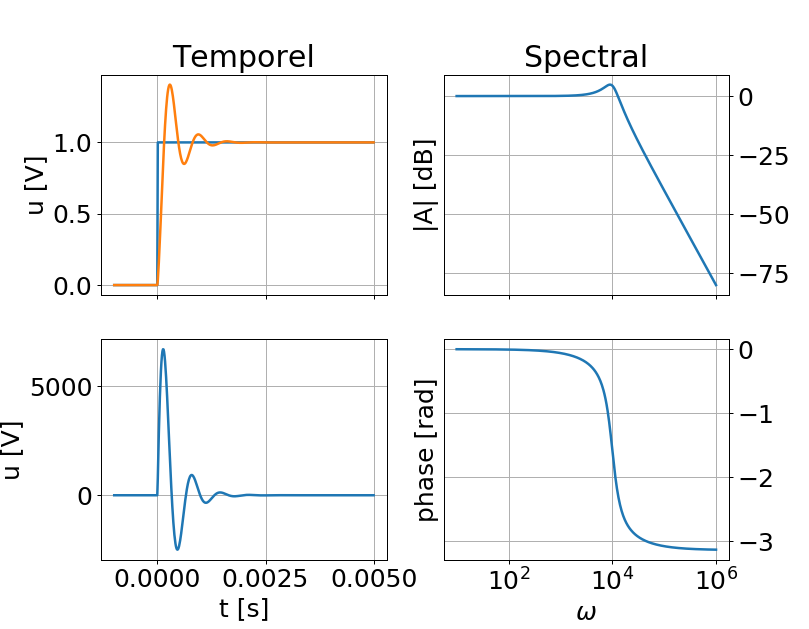

In [15]:
t = np.linspace(-.001, .005, 501)
omega = np.logspace(1, 6, 501)
u = (t>0)
m = 1
omega0 = 1e4 # log10 of omega0
d = np.zeros(t.size)
d[np.argmin(np.abs(t))] = 100

y = stepresponse(m, omega0)(t)
z = impulseresponse(m, omega0)(t)
amp, phase = frequencyresponse(m, omega0)
a = 20 * np.log(amp(omega)) / np.log(10)
phi = phase(omega)

fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(9, 7))
ax[1, 0].set_xlabel('t [s]')
ax[0, 0].set_title('Temporel')
ax[0, 0].set_ylabel('u [V]')
ax[1, 0].set_ylabel('u [V]')
ax[0, 1].yaxis.tick_right()
ax[1, 1].yaxis.tick_right()
ax[0, 1].set_ylabel('|A| [dB]')
ax[1, 1].set_ylabel('phase [rad]')

ax[1, 1].set_xlabel(r'$\omega$')
ax[0, 1].set_title('Spectral')

udata, = ax[0, 0].plot(t, u, label='unit step')
p00data, = ax[0, 0].plot(t, y, label='step')
p10data, = ax[1, 0].plot(t, z, label='impulse')
p01data, = ax[0, 1].semilogx(omega, a, label='amp')
p11data, = ax[1, 1].semilogx(omega, phi, label='phase')

for _ax in ax.flat:
    _ax.grid()
    _ax.autoscale(axis='y', tight=False)

event_handler = ZoomOnX(fig, t, omega, wgm.value, 10 ** wgomega.value)
    
wgomega.observe(event_handler.update_params, names='value')
wgm.observe(event_handler.update_params, names='value')

display(wgomega)
display(wgm)
